# I. Topic Modeling in Python: Latent Dirichlet Allocation (LDA)

Reference Article: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Github: https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb


## (Agenda) LDA Implementation:

1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Prepare data for LDA analysis
5. LDA model training
6. Analyzing LDA model results

### Step 1: Loading Data

In [1]:
# Importing modules
import pandas as pd
import os

# Read data 
rawdata = pd.read_csv('data/McDonalds.csv', encoding='latin1')
rawdata.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,policies_violated,policies_violated:confidence,city,policies_violated_gold,BadFood,Cost,Filthy,MissingFood,na,OrderProblem,RudeService,ScaryMcDs,SlowService,review
0,679455653,False,finalized,3,2/21/15 0:36,RudeService\rOrderProblem\rFilthy,1.0\r0.6667\r0.6667,Atlanta,NaN,0,0,1,0,0,1,1,0,0,"I'm not a huge mcds lover, but I've been to be..."
1,679455654,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,0,0,0,0,0,0,1,0,0,Terrible customer service. Î¾I came in at 9:30...
2,679455655,False,finalized,3,2/21/15 0:26,SlowService\rOrderProblem,1.0\r1.0,Atlanta,NaN,0,0,0,0,0,1,0,0,1,"First they ""lost"" my order, actually they gave..."
3,679455656,False,finalized,3,2/21/15 0:27,na,0.6667,Atlanta,NaN,0,0,0,0,1,0,0,0,0,I see I'm not the only one giving 1 star. Only...
4,679455657,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,0,0,0,0,0,0,1,0,0,"Well, it's McDonald's, so you know what the fo..."


### Step 2: Data Cleaning

In [2]:
data = rawdata.drop(columns=['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 
                             'policies_violated:confidence', 'city', 'policies_violated_gold', 'BadFood', 'Cost', 'Filthy', 
                             'MissingFood', 'na', 'OrderProblem', 'RudeService', 'ScaryMcDs', 'SlowService', 'policies_violated'], 
                    axis=1)

data.head()

,review
0,"I'm not a huge mcds lover, but I've been to be..."
1,Terrible customer service. Î¾I came in at 9:30...
2,"First they ""lost"" my order, actually they gave..."
3,I see I'm not the only one giving 1 star. Only...
4,"Well, it's McDonald's, so you know what the fo..."


#### Remove punctuation/lower casing

A simple preprocessing on the content of `reviews` column to make them more amenable for analysis, and reliable results. To do that, use a regular expression to remove any punctuation, and then lowercase the text.

In [3]:
# Load the regular expression library
import re

# Remove Punctuation
data['text_processed'] = data['review'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert text in reviews to lowercase
data['text_processed'] = data['text_processed'].map(lambda x: x.lower())

# Print out the first few rows of reviews
data['text_processed'].head()

0    i'm not a huge mcds lover but i've been to bet...
1    terrible customer service î¾i came in at 9:30p...
2    first they "lost" my order actually they gave ...
3    i see i'm not the only one giving 1 star only ...
4    well it's mcdonald's so you know what the food...
Name: text_processed, dtype: object

### Step 3: Exploratory Analysis

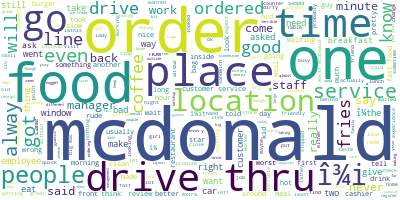

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed text together.
long_string = ','.join(list(data['text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Step 4: Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [5]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]



words = data.text_processed.values.tolist()
data_words = list(sent_to_words(words))


# remove stop words
data_words = remove_stopwords(data_words)

# print the first 30 words of 1st review
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /Users/joyce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['huge', 'mcds', 'lover', 'better', 'ones', 'far', 'worst', 'one', 'ever', 'filthy', 'inside', 'get', 'drive', 'completely', 'screw', 'order', 'every', 'time', 'staff', 'terribly', 'unfriendly', 'nobody', 'seems', 'care']


In [6]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]


### Step 5: LDA model tranining

To keep things simple, just keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [7]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"mcdonald" + 0.010*"drive" + 0.009*"food" + 0.009*"get" + '
  '0.009*"location" + 0.008*"go" + 0.008*"like" + 0.008*"one" + '
  '0.008*"mcdonalds" + 0.008*"i¾i"'),
 (1,
  '0.013*"food" + 0.012*"order" + 0.011*"get" + 0.010*"mcdonald" + '
  '0.009*"service" + 0.008*"time" + 0.007*"mcdonalds" + 0.006*"good" + '
  '0.006*"go" + 0.006*"fries"'),
 (2,
  '0.015*"order" + 0.013*"food" + 0.009*"one" + 0.009*"get" + '
  '0.008*"mcdonalds" + 0.007*"time" + 0.007*"i¾i" + 0.007*"drive" + '
  '0.007*"mcdonald" + 0.006*"like"'),
 (3,
  '0.016*"order" + 0.014*"one" + 0.009*"drive" + 0.008*"mcdonald" + '
  '0.008*"get" + 0.007*"go" + 0.006*"service" + 0.006*"thru" + 0.006*"coffee" '
  '+ 0.006*"food"'),
 (4,
  '0.012*"food" + 0.011*"time" + 0.009*"place" + 0.009*"service" + 0.009*"go" '
  '+ 0.008*"one" + 0.008*"mcdonald" + 0.008*"always" + 0.007*"mcdonalds" + '
  '0.006*"get"'),
 (5,
  '0.015*"mcdonald" + 0.009*"drive" + 0.009*"mcdonalds" + 0.008*"service" + '
  '0.007*"food" + 0.007*"o

### Step 6: Analyzing our LDA model

pyLDAvis: https://github.com/bmabey/pyLDAvis

In [8]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./data/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './data/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/Users/joyce/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.014786 -0.001251       1        1  17.103261
1      0.013956 -0.006310       2        1  16.412920
2      0.026612 -0.000228       3        1  14.389568
8     -0.004087  0.007463       4        1  11.835066
0      0.013037  0.004566       5        1   7.516570
7     -0.002193  0.017630       6        1   7.441073
4     -0.008392 -0.044703       7        1   7.208497
3      0.015222  0.023105       8        1   7.017496
9     -0.018312 -0.019133       9        1   6.114412
5     -0.050629  0.018862      10        1   4.961137, topic_info=         Term        Freq       Total Category  logprob  loglift
153  mcdonald  732.000000  732.000000  Default  30.0000  30.0000
14        one  675.000000  675.000000  Default  29.0000  29.0000
3       drive  605.000000  605.000000  Default  28.0000  28.0000
54    service  445.000000  445.000000  Default  27.0000  27.0000
38       food  769.000000  769.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
53        say    8.894030  151.854267  Topic10  -6.0128   0.1660
323     fries    9.702295  273.028588  Topic10  -5.9258  -0.3337
177     times    9.016898  183.282490  Topic10  -5.9991  -0.0084
4        ever    9.256707  239.058302  Topic10  -5.9729  -0.2478
96    manager    8.907439  194.341676  Topic10  -6.0113  -0.0792

[857 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2870      3  0.543587   abour
2637      1  0.536455  accept
2637      2  0.107291  accept
2637      3  0.107291  accept
2637      6  0.107291  accept
...     ...       ...     ...
1204      6  0.046748     yet
1204      7  0.023374     yet
1204      8  0.046748     yet
1204      9  0.046748     yet
1204     10  0.023374     yet

[2225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 3, 9, 1, 8, 5, 4, 10, 6])

# II. Evaluate Topic Models: Latent Dirichlet Allocation (LDA)

Reference Article: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Github: https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Evaluate%20Topic%20Models.ipynb

## (Agenda) Model Implementation:
1. Loading Data (-- skip --)
2. Data Cleaning (-- skip --)
3. Phrase Modeling: Bi-grams and Tri-grams
4. Data Transformation: Corpus and Dictionary
5. Base Model
6. Hyper-parameter Tuning
7. Final model
8. Visualize Results

### Step 2: Data Cleaning
 
*Note: remove punctuation / lower casing is same as the previous one --> Skip!

#### Tokenize words and further clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

*Note: remove punctuation and stopwords do together in previous one

In [9]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

words = data.text_processed.values.tolist()
data_words = list(sent_to_words(words))

print(data_words[:1][0][:30])

['not', 'huge', 'mcds', 'lover', 'but', 've', 'been', 'to', 'better', 'ones', 'this', 'is', 'by', 'far', 'the', 'worst', 'one', 've', 'ever', 'been', 'too', 'it', 'filthy', 'inside', 'and', 'if', 'you', 'get', 'drive', 'through']


### Step 3: Phrase Modeling: Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: 'back_bumper', 'oil_leakage', 'maryland_college_park' etc.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Remove Stopwords, Make Bigrams and Lemmatize

The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

In [11]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /Users/joyce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

/Users/joyce/opt/anaconda3/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


['huge', 'mcds', 'lover', 'well', 'one', 'far', 'worst', 'ever', 'filthy', 'inside', 'get', 'drive', 'completely', 'screw', 'order', 'time', 'staff', 'terribly', 'unfriendly', 'seem', 'care']


### Step 4: Data transformation: Corpus and Dictionary


The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. 

In [17]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]


### Step 5: Base Model

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).

`chunksize` controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

`passes` controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [18]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

See the keywords for each topic and the weightage (importance) of each keyword using `lda_model.print_topics()`.

In [20]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"order" + 0.018*"mcdonald" + 0.015*"place" + 0.015*"get" + '
  '0.014*"food" + 0.014*"go" + 0.011*"i¾i" + 0.010*"time" + 0.008*"eat" + '
  '0.008*"take"'),
 (1,
  '0.023*"order" + 0.023*"go" + 0.021*"get" + 0.017*"food" + 0.016*"wait" + '
  '0.016*"mcdonald" + 0.015*"time" + 0.012*"line" + 0.011*"people" + '
  '0.010*"window"'),
 (2,
  '0.019*"manager" + 0.013*"crowd" + 0.012*"tea" + 0.011*"ask" + '
  '0.011*"counter" + 0.011*"car" + 0.010*"employee" + 0.010*"pie" + '
  '0.010*"order" + 0.010*"customer"'),
 (3,
  '0.013*"race" + 0.013*"black" + 0.012*"aggressive" + 0.012*"youth" + '
  '0.012*"thuggery" + 0.010*"group" + 0.007*"tower" + 0.007*"checking" + '
  '0.007*"mcwrap" + 0.007*"buy"'),
 (4,
  '0.014*"angry" + 0.010*"behavior" + 0.010*"fighting" + 0.010*"manager" + '
  '0.009*"roof" + 0.008*"sugar" + 0.008*"coffee" + 0.008*"milk" + '
  '0.007*"burger" + 0.006*"mcdonald"'),
 (5,
  '0.033*"order" + 0.022*"get" + 0.021*"go" + 0.019*"service" + 0.018*"bad" + '
  '0.015*"w

#### Compute Model Perplexity and Coherence Score

In [21]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4277759414006611


### Step 6: Hyperparameter tuning

First, let's differentiate between model hyperparameters and model parameters :

- `Model hyperparameters` can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

- `Model parameters` can be thought of as what the model learns during training, such as the weights for each word in a given topic.

Now that we have the baseline coherence score for the default LDA model, let's perform a series of sensitivity tests to help determine the following model hyperparameters:

- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document - Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

We'll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two difference validation corpus sets. We'll use `C_v` as our choice of metric for performance comparison.

*Note: `C_v` measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity.

In [22]:
# Supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [25]:
%%time

import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }


# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./data/lda_tuning_results.csv', index=False)
    pbar.close()



  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 1/540 [00:23<3:35:15, 23.96s/it]

  0%|          | 2/540 [00:43<3:23:23, 22.68s/it]

  1%|          | 3/540 [01:03<3:14:51, 21.77s/it]

  1%|          | 4/540 [01:23<3:09:40, 21.23s/it]

  1%|          | 5/540 [01:43<3:06:52, 20.96s/it]

  1%|          | 6/540 [02:02<3:01:40, 20.41s/it]

  1%|▏         | 7/540 [02:20<2:54:53, 19.69s/it]

  1%|▏         | 8/540 [02:39<2:52:33, 19.46s/it]

  2%|▏         | 9/540 [02:57<2:48:08, 19.00s/it]

  2%|▏         | 10/540 [03:15<2:46:08, 18.81s/it]

  2%|▏         | 11/540 [03:35<2:48:48, 19.15s/it]

  2%|▏         | 12/540 [03:56<2:53:01, 19.66s/it]

  2%|▏         | 13/540 [04:15<2:51:25, 19.52s/it]

  3%|▎         | 14/540 [04:34<2:49:52, 19.38s/it]

  3%|▎         | 15/540 [04:54<2:48:45, 19.29s/it]

  3%|▎         | 16/540 [05:11<2:43:23, 18.71s/it]

  3%|▎         | 17/540 [05:30<2:43:41, 18.78s/it]

  3%|▎         | 18/540 [05:48<2:42:38, 18.70s/it]

  4%|▎         | 19/540 [06:07

 26%|██▌       | 140/540 [48:57<2:25:22, 21.81s/it]

 26%|██▌       | 141/540 [49:22<2:30:14, 22.59s/it]

 26%|██▋       | 142/540 [49:41<2:22:34, 21.49s/it]

 26%|██▋       | 143/540 [50:01<2:19:17, 21.05s/it]

 27%|██▋       | 144/540 [50:21<2:16:43, 20.72s/it]

 27%|██▋       | 145/540 [50:42<2:17:59, 20.96s/it]

 27%|██▋       | 146/540 [51:07<2:24:42, 22.04s/it]

 27%|██▋       | 147/540 [51:27<2:20:43, 21.48s/it]

 27%|██▋       | 148/540 [51:48<2:18:57, 21.27s/it]

 28%|██▊       | 149/540 [52:08<2:15:59, 20.87s/it]

 28%|██▊       | 150/540 [52:30<2:17:37, 21.17s/it]

 28%|██▊       | 151/540 [52:50<2:15:23, 20.88s/it]

 28%|██▊       | 152/540 [53:11<2:14:52, 20.86s/it]

 28%|██▊       | 153/540 [53:32<2:15:49, 21.06s/it]

 29%|██▊       | 154/540 [53:52<2:14:10, 20.86s/it]

 29%|██▊       | 155/540 [54:15<2:17:43, 21.46s/it]

 29%|██▉       | 156/540 [54:39<2:21:11, 22.06s/it]

 29%|██▉       | 157/540 [54:58<2:14:24, 21.06s/it]

 29%|██▉       | 158/540 [55:15<2:07:53, 20.09

 51%|█████     | 275/540 [1:41:46<7:55:40, 107.70s/it]

 51%|█████     | 276/540 [3:17:45<132:13:00, 1802.96s/it]

 51%|█████▏    | 277/540 [3:18:27<93:07:37, 1274.74s/it] 

 51%|█████▏    | 278/540 [3:19:01<65:41:11, 902.56s/it] 

 52%|█████▏    | 279/540 [3:19:44<46:44:10, 644.64s/it]

 52%|█████▏    | 280/540 [5:27:22<198:31:05, 2748.71s/it]

 52%|█████▏    | 281/540 [5:28:09<139:26:35, 1938.21s/it]

 52%|█████▏    | 282/540 [5:28:33<97:44:34, 1363.85s/it] 

 52%|█████▏    | 283/540 [5:28:59<68:42:26, 962.44s/it] 

 53%|█████▎    | 284/540 [5:29:19<48:20:49, 679.88s/it]

 53%|█████▎    | 285/540 [5:29:38<34:06:41, 481.57s/it]

 53%|█████▎    | 286/540 [5:29:56<24:09:47, 342.47s/it]

 53%|█████▎    | 287/540 [5:30:14<17:14:11, 245.26s/it]

 53%|█████▎    | 288/540 [5:30:34<12:26:16, 177.68s/it]

 54%|█████▎    | 289/540 [5:30:53<9:04:04, 130.06s/it] 

 54%|█████▎    | 290/540 [5:31:13<6:43:33, 96.86s/it] 

 54%|█████▍    | 291/540 [5:31:31<5:04:14, 73.31s/it]

 54%|█████▍    | 292/54

 76%|███████▌  | 410/540 [6:09:21<41:43, 19.26s/it]

 76%|███████▌  | 411/540 [6:09:39<41:05, 19.11s/it]

 76%|███████▋  | 412/540 [6:09:58<40:22, 18.93s/it]

 76%|███████▋  | 413/540 [6:10:16<39:41, 18.75s/it]

 77%|███████▋  | 414/540 [6:10:35<39:15, 18.70s/it]

 77%|███████▋  | 415/540 [6:10:55<40:00, 19.21s/it]

 77%|███████▋  | 416/540 [6:11:14<39:37, 19.17s/it]

 77%|███████▋  | 417/540 [6:11:34<39:30, 19.27s/it]

 77%|███████▋  | 418/540 [6:11:56<40:51, 20.10s/it]

 78%|███████▊  | 419/540 [6:12:14<39:33, 19.62s/it]

 78%|███████▊  | 420/540 [6:12:35<39:54, 19.96s/it]

 78%|███████▊  | 421/540 [6:12:55<39:27, 19.90s/it]

 78%|███████▊  | 422/540 [6:13:14<38:34, 19.61s/it]

 78%|███████▊  | 423/540 [6:13:33<37:53, 19.43s/it]

 79%|███████▊  | 424/540 [6:13:51<37:04, 19.18s/it]

 79%|███████▊  | 425/540 [6:14:11<37:05, 19.35s/it]

 79%|███████▉  | 426/540 [6:14:31<37:00, 19.48s/it]

 79%|███████▉  | 427/540 [6:14:50<36:38, 19.46s/it]

 79%|███████▉  | 428/540 [6:15:10<36:16, 19.43

CPU times: user 28min 31s, sys: 4min 23s, total: 32min 54s
Wall time: 6h 50min 8s


### Step 7: Final Model

In [27]:
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [29]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"order" + 0.017*"get" + 0.016*"go" + 0.015*"mcdonald" + 0.013*"food" '
  '+ 0.011*"time" + 0.008*"place" + 0.008*"service" + 0.007*"take" + '
  '0.007*"say"'),
 (1,
  '0.002*"lobby" + 0.001*"body" + 0.001*"light" + 0.001*"feature" + '
  '0.001*"hospital" + 0.001*"i¾messe" + 0.001*"ketchup" + 0.001*"tow" + '
  '0.001*"client" + 0.001*"i¾misse"'),
 (2,
  '0.002*"black" + 0.002*"race" + 0.002*"thuggery" + 0.002*"youth" + '
  '0.002*"aggressive" + 0.002*"gang" + 0.002*"neighborhood" + 0.001*"become" + '
  '0.001*"thug" + 0.001*"obscenity"'),
 (3,
  '0.001*"nail" + 0.001*"eyed" + 0.001*"escort" + 0.001*"weapon" + '
  '0.000*"soap" + 0.000*"quarterpounder" + 0.000*"technology" + 0.000*"paint" '
  '+ 0.000*"fuel" + 0.000*"dream"'),
 (4,
  '0.001*"online" + 0.001*"cheddar" + 0.001*"splash" + 0.000*"particularly" + '
  '0.000*"materialize" + 0.000*"centrally" + 0.000*"blade" + '
  '0.000*"therestill" + 0.000*"grimy" + 0.000*"razor"'),
 (5,
  '0.001*"laptop" + 0.001*"song" + 0.001*

In [31]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./data/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './data/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

/Users/joyce/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.247795 -0.000147       1        1  95.051722
1     -0.035645  0.011505       2        1   1.366474
5     -0.035980  0.003085       3        1   0.876262
6     -0.035234  0.001550       4        1   0.809582
2     -0.037832 -0.018184       5        1   0.673225
7     -0.034606  0.001016       6        1   0.514323
3     -0.034964  0.000872       7        1   0.476806
4     -0.033535  0.000303       8        1   0.231606, topic_info=              Term        Freq       Total Category  logprob  loglift
1248  neighborhood   40.000000   40.000000  Default  30.0000  30.0000
276          black   29.000000   29.000000  Default  29.0000  29.0000
36              i¾  100.000000  100.000000  Default  28.0000  28.0000
1174         shake   28.000000   28.000000  Default  27.0000  27.0000
352        include   41.000000   41.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
4665       specify    0.046867    3.205279   Topic8  -8.0084   1.8426
1706       strange    0.050114    7.183422   Topic8  -7.9414   1.1027
152           folk    0.046905   12.698659   Topic8  -8.0076   0.4668
3714          i¾oh    0.045775    4.731247   Topic8  -8.0320   1.4297
1249          news    0.045611    3.815840   Topic8  -8.0356   1.6411

[384 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6188      1  0.701850  accomplish
3486      1  0.966216      accost
1215      1  0.827337    activity
6471      1  0.444889    againand
6471      2  0.444889    againand
...     ...       ...         ...
5003      1  0.755787       yesdo
6509      1  0.828387      yogurt
6509      2  0.138065      yogurt
6548      1  0.501545       youth
6548      5  0.501545       youth

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 7, 3, 8, 4, 5])